https://github.com/masterTW/Tensorflow_NIMA_Food_Photo_Aesthetic_Evaluation
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [0]:
from google.colab import drive

import os
import io
import tarfile
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import sys
import argparse
import os
import random
import shutil

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [6]:
#%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [7]:
print(torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0))

True 1 Tesla K80


In [8]:
drive.mount("/content/gdrive")
if not os.path.exists("small"):
  !cp "/content/gdrive/My Drive/Data Science/small.tar" .
  !tar -xf small.tar
  !mkdir data
  !mkdir data/small_good

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Here we filter the well scored images from out dataset for use in our GAN
if len(os.listdir("data/small_good/")) < 100:
  # load labels
  all_labels = pd.read_csv("/content/gdrive/My Drive/Data Science/AVA.txt",
                            sep = " ",
                            names=["id", 
                                  "img_id",
                                  "r_01", 
                                  "r_02", 
                                  "r_03", 
                                  "r_04", 
                                  "r_05", 
                                  "r_06", 
                                  "r_07", 
                                  "r_08", 
                                  "r_09", 
                                  "r_10",
                                  "im_tag_1",
                                  "im_tag_2",
                                  "challenge_id"])

  # normalize ratings
  all_labels["r_sum"] = all_labels.iloc[:,2:12].sum(axis=1)
  for i in range(1, 11):
    col_name = "r_" + str(i).rjust(2, "0")
    all_labels[col_name] = all_labels[col_name].astype("float") / all_labels["r_sum"]

  # reduce labels to the stuff we need
  reduced_labels = all_labels.drop(["id", "im_tag_1", "im_tag_2", "challenge_id", "r_sum"], axis = 1)

  for index, row in reduced_labels.iterrows():
    img_id = int(row["img_id"])
    img_name = str(img_id) + ".jpg"
    score = row[1:].to_numpy().dot(np.array([1,2,3,4,5,6,7,8,9,10]))
    if score > 6:
      try:
        shutil.copyfile(os.path.join("small/", img_name), os.path.join("data/small_good/", img_name))
      except:
        print(img_name + " does not exist")

In [0]:
# Root directory for dataset
dataroot = "data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Magnitude of noise to add to generator output and real images
img_noise_mag = 0.01

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8), dpi=128)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [0]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # input is Z, going into a convolution
      nn.ConvTranspose2d(in_channels=nz, 
                         out_channels=ngf*16, 
                         kernel_size=4, 
                         stride=1, 
                         padding=0, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*16),
      nn.ReLU(True),
      # state size. (ngf*16) x 4 x 4
      nn.ConvTranspose2d(in_channels=ngf*16, 
                         out_channels=ngf*8, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*8),
      nn.ReLU(True),
      # state size. (ngf*8) x 8 x 8
      nn.ConvTranspose2d(in_channels=ngf*8, 
                         out_channels=ngf*4, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*4),
      nn.ReLU(True),
      # state size. (ngf*4) x 16 x 16
      nn.ConvTranspose2d(in_channels=ngf*4, 
                         out_channels=ngf*2, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*2),
      nn.ReLU(True),
      # state size. (ngf*2) x 32 x 32
      nn.ConvTranspose2d(in_channels=ngf*2, 
                         out_channels=ngf, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf),
      nn.ReLU(True),
      # state size. (ngf) x 64 x 46
      nn.ConvTranspose2d(in_channels=ngf, 
                         out_channels=nc, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.Tanh()
      # state size. (nc) x 128 x 128
    )
  def forward(self, input):
      return self.main(input)

In [14]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netG.apply(weights_init)

# Print the model
print(netG)
print(sum(p.numel() for p in netG.parameters()))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [0]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # input is (nc) x 128 x 128
      nn.Conv2d(in_channels=nc, 
                out_channels=ndf,
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf) x 64 x 64
      nn.Conv2d(in_channels=ndf, 
                out_channels=ndf*2,  
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.BatchNorm2d(num_features=ndf*2),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*2) x 32 x 32
      nn.Conv2d(in_channels=ndf*2,
                out_channels=ndf*4,  
                kernel_size=4, 
                stride=2, 
                padding=1,
                bias=False),
      nn.BatchNorm2d(num_features=ndf*4),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*4) x 16 x 16
      nn.Conv2d(in_channels=ndf*4, 
                out_channels=ndf*8, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.BatchNorm2d(num_features=ndf*8),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*8) x 8 x 8
      nn.Conv2d(in_channels=ndf*8, 
                out_channels=ndf*16,  
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.BatchNorm2d(num_features=ndf*16),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*16) x 4 x 4
      nn.Conv2d(in_channels=ndf*16,
                out_channels=1,  
                kernel_size=4, 
                stride=1,
                padding=0, 
                bias=False),
      nn.Sigmoid()
    )
  def forward(self, input):
    return self.main(input)

In [16]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netD.apply(weights_init)

# Print the model
print(netD)
print(sum(p.numel() for p in netD.parameters()))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
  # For each batch in the dataloader
  for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    label = torch.full((b_size,), real_label, device=device)
    # Forward pass real batch through D
    output = netD(real_cpu + img_noise).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake + img_noise).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    # we do two steps here to balance the generator and discriminator
    ###########################
    #first step
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake.detach() + img_noise).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G xxx
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()

    # second step
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    # Classify all fake batch with D
    output = netD(fake + img_noise).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()
    
    # third step
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    # Classify all fake batch with D
    output = netD(fake + img_noise).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()

    # Output training stats
    if i % 100 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        % (epoch+1, num_epochs, i, len(dataloader),
            errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1

Starting Training Loop...


[1/40][0/777]	Loss_D: 1.3793	Loss_G: 0.0504	D(x): 0.4317	D(G(z)): 0.3969 / 0.9511
[1/40][100/777]	Loss_D: 1.0343	Loss_G: 1.3522	D(x): 0.5554	D(G(z)): 0.3247 / 0.2842
[1/40][200/777]	Loss_D: 1.6466	Loss_G: 1.4386	D(x): 0.4877	D(G(z)): 0.5265 / 0.2795
[1/40][300/777]	Loss_D: 1.7436	Loss_G: 1.1658	D(x): 0.4189	D(G(z)): 0.5493 / 0.3337
[1/40][400/777]	Loss_D: 1.3796	Loss_G: 0.6927	D(x): 0.5578	D(G(z)): 0.5385 / 0.5142
[1/40][500/777]	Loss_D: 1.4883	Loss_G: 0.6692	D(x): 0.5137	D(G(z)): 0.5504 / 0.5173
[1/40][600/777]	Loss_D: 1.5337	Loss_G: 0.8145	D(x): 0.4941	D(G(z)): 0.5466 / 0.4520
[1/40][700/777]	Loss_D: 1.5076	Loss_G: 0.6650	D(x): 0.4665	D(G(z)): 0.4943 / 0.5178



[2/40][0/777]	Loss_D: 1.4650	Loss_G: 0.8059	D(x): 0.4833	D(G(z)): 0.5034 / 0.4534


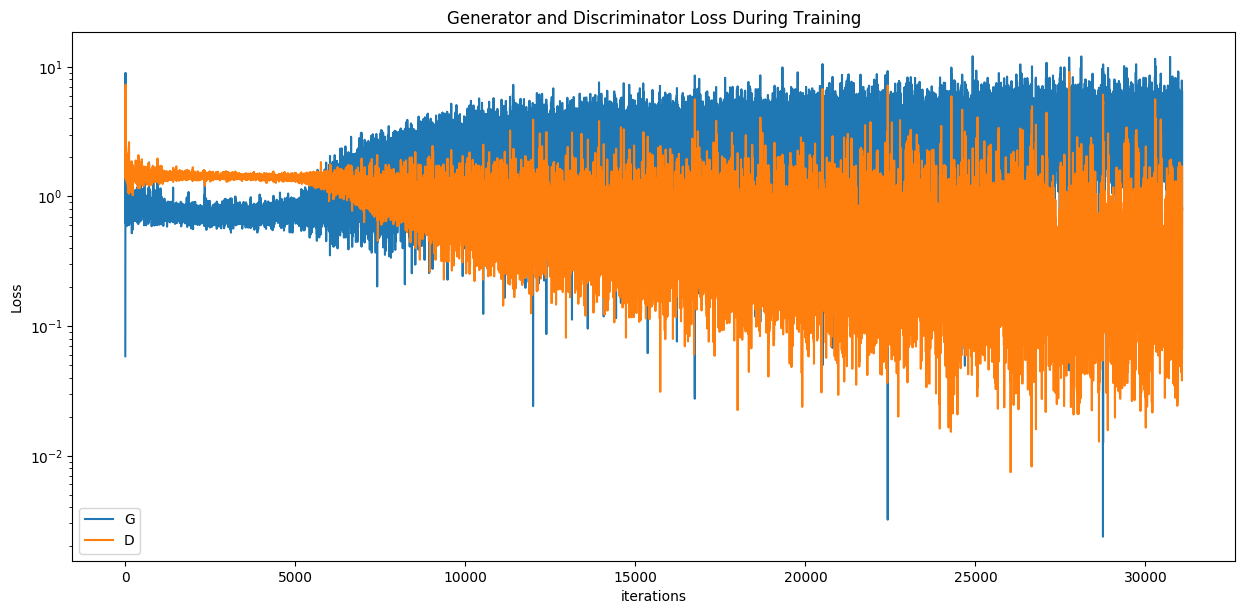

In [0]:
plt.figure(figsize=(15,7), dpi=100)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=32)
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(16,8), dpi=128)
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Plot the fake images from the last epoch
plt.figure(figsize=(8,8), dpi=128)
plt.axis("off")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()